In [2]:
import numpy as np
import matplotlib.pyplot as plt
import batman
from astropy.time import Time
import matplotlib.pyplot as plt
from io import StringIO
import emcee
import corner
from mc3.stats import time_avg
from matplotlib.ticker import ScalarFormatter




In [4]:
eclipses = ['1', '2', '3']

amps = {e: [] for e in eclipses}
amps_err = {e: [] for e in eclipses}
time = {e: [] for e in eclipses}
data = {e: [] for e in eclipses}

for e in eclipses:
    file_path = '/Users/alexandrarochon/Programming/LHS1140-Eureka/etienne-LC/photometry_eclipse'+e+'_corr.rdb' 
    # Read the file and skip the second line (with dashes)
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Remove the second line (with dashes)
    lines = [line for i, line in enumerate(lines) if i != 1]

    # Save the cleaned content into a temporary variable
    cleaned_file = StringIO(''.join(lines))

    # Load using genfromtxt, with names from header
    data[e] = np.genfromtxt(cleaned_file, delimiter='\t', names=True, dtype=None, encoding='utf-8')

    # Access the columns
    amps[e] = data[e]['amps_detrended']
    amps_err[e] = data[e]['amps_err_detrended']
    time[e] = data[e]['int_mid_MJD_UTC'] # use barycentric time instead???



In [5]:
ecl1 = Time('2023-11-27 21:00', format = 'iso', scale = 'tdb')
ecl2 = Time('2024-07-07 18:34', format = 'iso', scale = 'tdb')
ecl3 = Time('2024-07-19 02:34', format = 'iso', scale = 'tdb')
ecl1 = ecl1.mjd
ecl2 = ecl2.mjd
ecl3 = ecl3.mjd
print(ecl1, ecl2, ecl3)


temp_time = time['1']
time['1'] = time['2']
time['2'] = temp_time
temp_amps = amps['1']
amps['1'] = amps['2']
amps['2'] = temp_amps
temp_amps_err = amps_err['1']
amps_err['1'] = amps_err['2']
amps_err['2'] = temp_amps_err

print(time['1'])

60275.875 60498.77361111111 60510.106944444444
[60275.77332581 60275.77345408 60275.77358235 ... 60275.93456085
 60275.93468912 60275.93481739]


(0.997, 1.003)

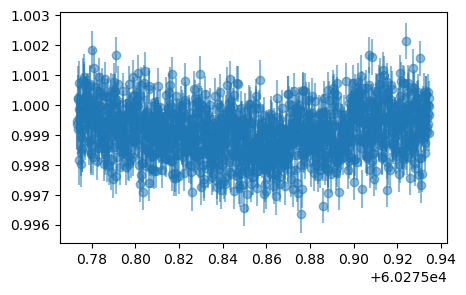

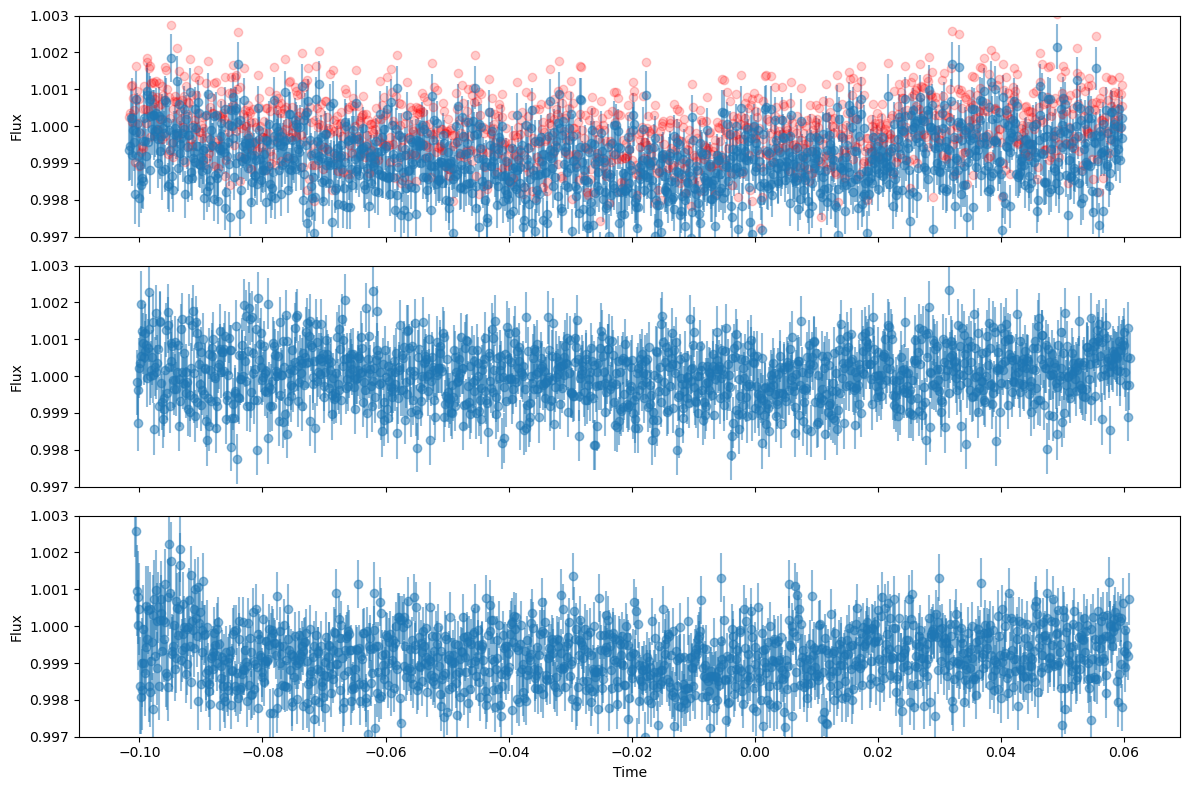

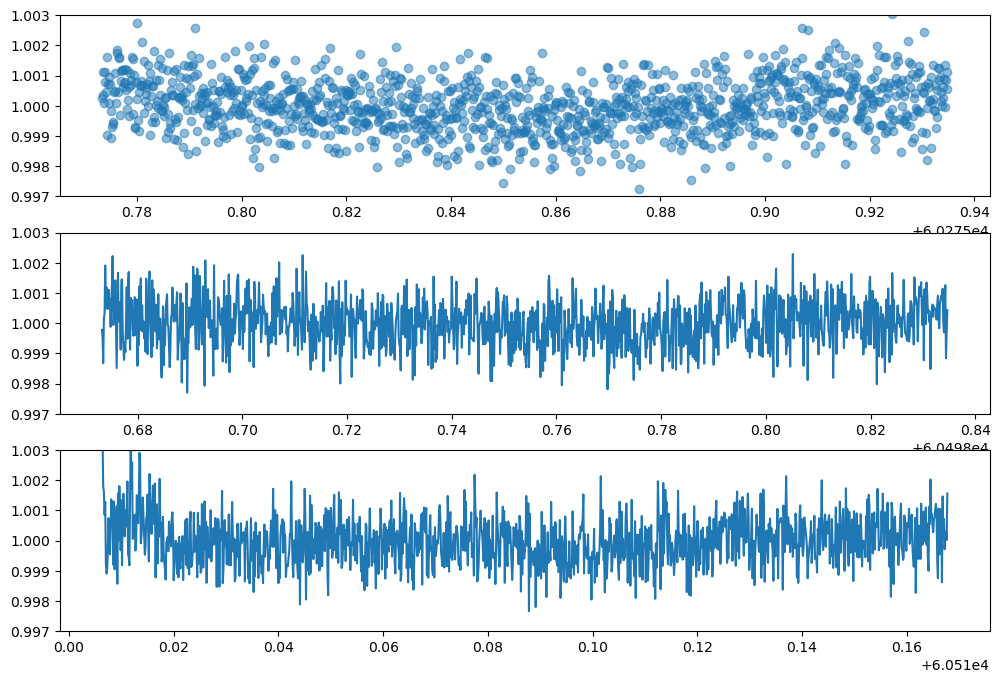

In [26]:
plt.figure(figsize=(5, 3))
plt.errorbar(time['1'], amps['1'], yerr=amps_err['1'], alpha=0.5, fmt='o')

fig, ax = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
ax[0].errorbar(time['1']-ecl1, amps['1'], yerr=amps_err['1'], alpha=0.5, fmt='o')
ax[0].plot(time['1']-ecl1, norm_amps1, 'ro',alpha = 0.2)

ax[1].errorbar(time['2']-ecl2, amps['2'], yerr=amps_err['2'], alpha=0.5, fmt='o')
ax[2].errorbar(time['3']-ecl3, amps['3'], yerr=amps_err['3'], alpha=0.5, fmt='o')
# ax[0].vlines(x=ecl1, ymin=0.09, ymax=1.02, color='k', linestyle='--', label='Eclipse 1')
# ax[1].vlines(x=ecl2, ymin=0.09, ymax=1.02, color='k', linestyle='--', label='Eclipse 2')
# ax[2].vlines(x=ecl3, ymin=0.09, ymax=1.02, color='k', linestyle='--', label='Eclipse 3')
ax[0].set_ylim(0.997, 1.003)
ax[1].set_ylim(0.997, 1.003)
ax[2].set_ylim(0.997, 1.003)

ax[2].set_xlabel('Time')
ax[0].set_ylabel('Flux')
ax[1].set_ylabel('Flux')
ax[2].set_ylabel('Flux')
# remove h space
plt.tight_layout()

# normalize
norm_amps_err1 = amps_err['1'] / np.mean(amps['1'])
norm_amps1 = amps['1'] / np.mean(amps['1'])

norm_amps_err2 = amps_err['2'] / np.mean(amps['2'])
norm_amps2 = amps['2'] / np.mean(amps['2'])

norm_amps_err3 = amps_err['3'] / np.mean(amps['3'])
norm_amps3 = amps['3'] / np.mean(amps['3'])

# fig, ax = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
# ax[0].errorbar(time['1']-ecl1, norm_amps_err1, yerr=amps_err, alpha=0.5, fmt='o')
# ax[1].errorbar(time['2']-ecl2, norm_amps_err2, yerr=amps_err2, alpha=0.5, fmt='o')
# ax[2].errorbar(time['3']-ecl3, norm_amps_err3, yerr=amps_err3, alpha=0.5, fmt='o')

fig, ax = plt.subplots(3,1, figsize=(12, 8))
ax[0].plot(time['1'], norm_amps1, 'o',alpha = 0.5)
ax[1].plot(time['2'], norm_amps2)
ax[2].plot(time['3'], norm_amps3)
ax[0].set_ylim(0.997, 1.003)
ax[1].set_ylim(0.997, 1.003)
ax[2].set_ylim(0.997, 1.003)
# expected eclipse is at 0


In [27]:
amps_arr = np.concatenate([amps['1'], amps['2'], amps['3']])
time_arr = np.concatenate([time['1'], time['2'], time['3']])
amps_err_arr = np.concatenate([amps_err['1'], amps_err['2'], amps_err['3']])

norm_amps_arr = np.concatenate([norm_amps1, norm_amps2, norm_amps3])
t_s = ecl1
fp = 0.000270
p0_astro = np.array([t_s, fp]) 

e_dur = 1.13 # hours
e_dur_days = e_dur / 24
print (ecl1)

60275.875


In [28]:
def transit_model(time, t_s, fp):
    # this model is based on the batman package
    # fits specifically for secondary eclipses
    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = 58388.7939                #time of inferior conjunction
    params.per = 3.777940                 #orbital period in hours
    params.rp = 0.0539                    #planet radius (in units of stellar radii) # check that this is ratio of radii -> 0.0539 is charles value
    params.a = 26.57                      #semi-major axis (in units of stellar radii)
    params.inc = 89.8                     #orbital inclination (in degrees)
    params.ecc = 0.                       #eccentricity
    params.w = 90.                        #longitude of periastron (in degrees)
    params.limb_dark = "quadratic"        #limb darkening model
    params.u = [0.16, 0.22]               #limb darkening coefficients, values from cadieux 2024b
    params.fp = fp                        #planet to star flux ratio
    params.t_secondary = t_s

    m = batman.TransitModel(params, time, transittype="secondary")
    flux = m.light_curve(params)
    return flux


(0.997, 1.003)

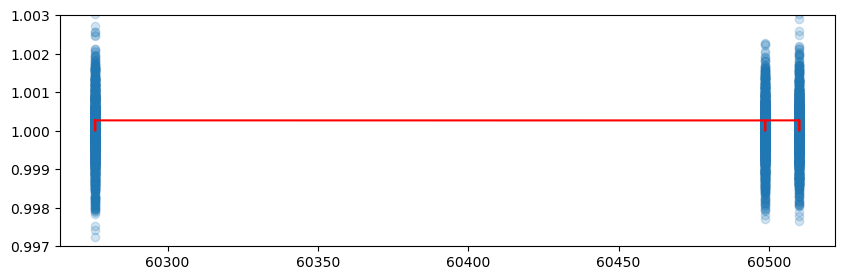

In [30]:
flux = transit_model(time_arr, ecl1, 0.000270)

plt.figure(figsize=(10, 3))
plt.plot(time_arr, norm_amps_arr, 'o', alpha=0.2, label='Data')
plt.plot(time_arr, flux, '-r')
plt.ylim(0.997, 1.003)
#plt.xlim(time_arr[0], time_arr[1250])


In [37]:
# MCMC functions
def log_likelihood(theta, time, flux):
    t_s, fp, sigF = theta  # time of secondary eclipse
    model = transit_model(time, t_s, fp)
    sigma2 = sigF**2
    return -0.5 * np.sum((flux - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    prior = 0.
    t_s = theta[0]
    fp = theta[1]
    sigF = theta[2]
    
    if (0 < fp < 1 and (ecl1 - (e_dur_days/2)) < t_s < (ecl1 + (e_dur_days/2)) and sigF > 0.):
        return 0.0 + prior
    return np.inf

def log_prob(theta, time, flux):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, time, flux)

In [38]:
p0 = np.concatenate((p0_astro, [0.001]))
nsteps, nwalkers, ndim = 15000, 70, len(p0)

# lower the initial position scatter
pos = p0 + 1e-5 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(time_arr, norm_amps_arr))

pos2, prob, state = sampler.run_mcmc(pos, nsteps, progress=True)

100%|██████████| 15000/15000 [05:13<00:00, 47.83it/s]


In [39]:
nBurnInSteps2 = 1000
lnprobchain = sampler.get_log_prob(discard=nBurnInSteps2).swapaxes(0,1)
chain = sampler.get_chain(discard=nBurnInSteps2).swapaxes(0,1)

# Save the chains
savepath = 'EtienneFits/try10-20000steps-joint_'
pathchain = savepath + 'samplerchain.npy'
pathlnlchain = savepath + 'samplerlnlchain.npy'
pathposit = savepath + 'samplerposi.npy'
pathlnpro = savepath + 'samplerlnpr.npy'
np.save(pathchain, chain)
np.save(pathlnlchain, lnprobchain)
np.save(pathposit, pos2)
np.save(pathlnpro, prob)

#tries
# 1 no prior on fp
# 2 very tight prior on fp, fp=286
# 3 tight prior on fp, fp=180, very poorly constrained
# 4 tight prior on fp, fp=280, poorly constrained, baseline seems overestimated (all?), walkers dont seem to be moving (in posterior plot)
# 5 tight prior on fp, initial position scatter 1e-6 (before e-5), fp=270, walkers not moving
# 6 tight (adjusted +/- 1 OOM) prior on fp, initial position scatter 1e-4, 70000 steps, 150 walkers, fp = 170
# might have been discarding too many burnin steps, so try again with 1000 burnin steps
# 7  no prior on fp, no prior on ts, initial position scatter 1e-5, bad -> retrying with 1/2 eclipse dur on each side of t_s and less walkers/steps, fp is centered at lower limit
# 8 bin data
# 10 re-normalized the LC !!

In [47]:
# # load previous results
# path = 'EtienneFits/try2-1000steps-joint_'
# chain = np.load(path +'samplerchain_10000.npy')
# lnprobchain = np.load(path  + 'samplerlnlchain_10000.npy')
# pos2 = np.load(path + 'samplerlnlchain_10000.npy')
# prob = np.load(path + 'samplerlnlchain_10000.npy')

In [40]:
samples = chain.reshape((-1, ndim))

MCMC_Results = np.array(list(map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84],axis=0)))))

maxk, maxiter = np.unravel_index((lnprobchain).argmax(), (lnprobchain).shape)
p0_mcmc = chain[maxk, maxiter,:]
for i in range(len(p0_mcmc)):
    MCMC_Results[i] = (p0_mcmc[i], MCMC_Results[i][1], MCMC_Results[i][2])

p0_labels = ['t_s','fp', 'sigF']
p0_labels[ndim-1] ='sigF'

out = "MCMC result:\n\n"
for i in range(len(p0_mcmc)):
    out += '{:>8} = {:>16}  +{:>16}  -{:>16}\n'.format(p0_labels[i],MCMC_Results[i][0], MCMC_Results[i][1], MCMC_Results[i][2])
print(out, flush=True)
textfile = savepath + 'results.txt'
with open(textfile, 'w') as f:
    f.write(out)


MCMC result:

     t_s = 60275.867497486455  +0.001546116553072352  -0.001495411925134249
      fp = 9.986700590197914e-05  +1.5765267215507787e-05  -1.5825527445111626e-05
    sigF = 0.0008128916452848454  +9.394690687168292e-06  -9.23750867651914e-06



(0.997, 1.003)

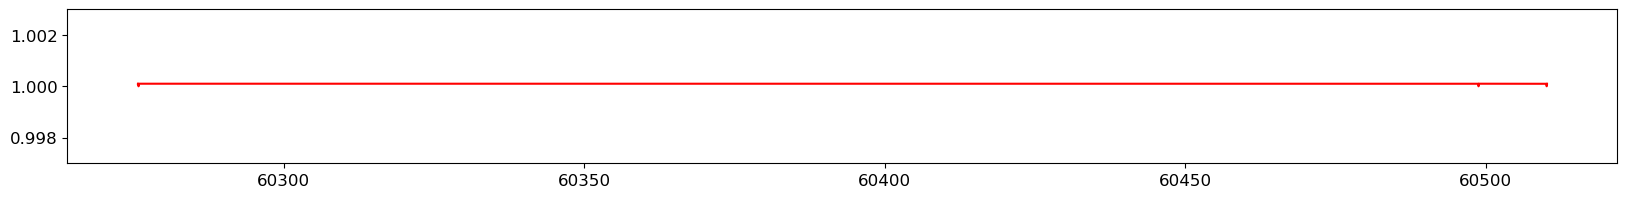

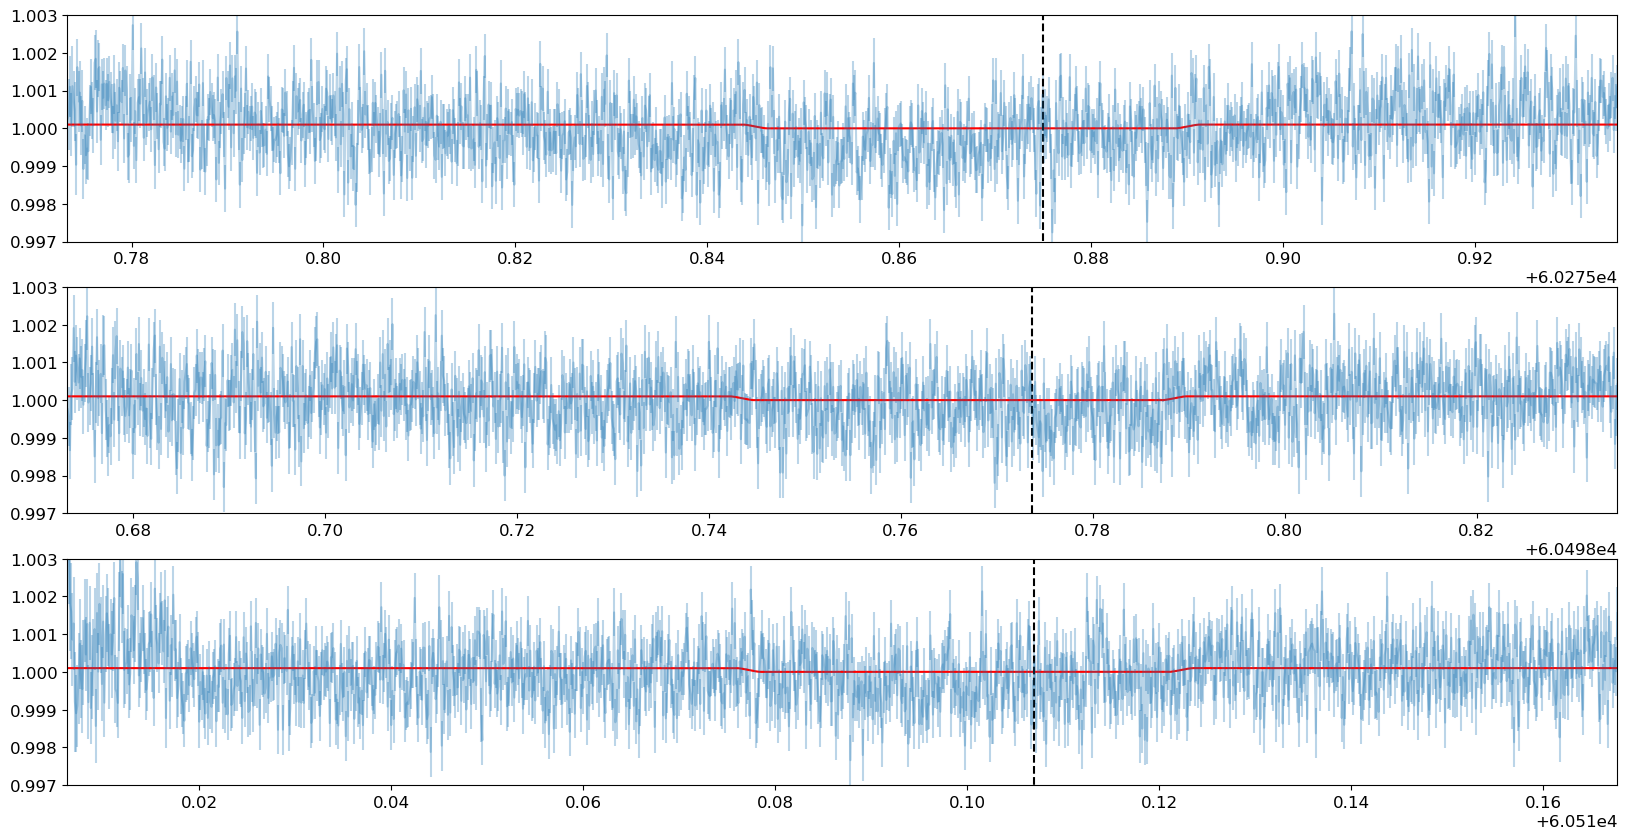

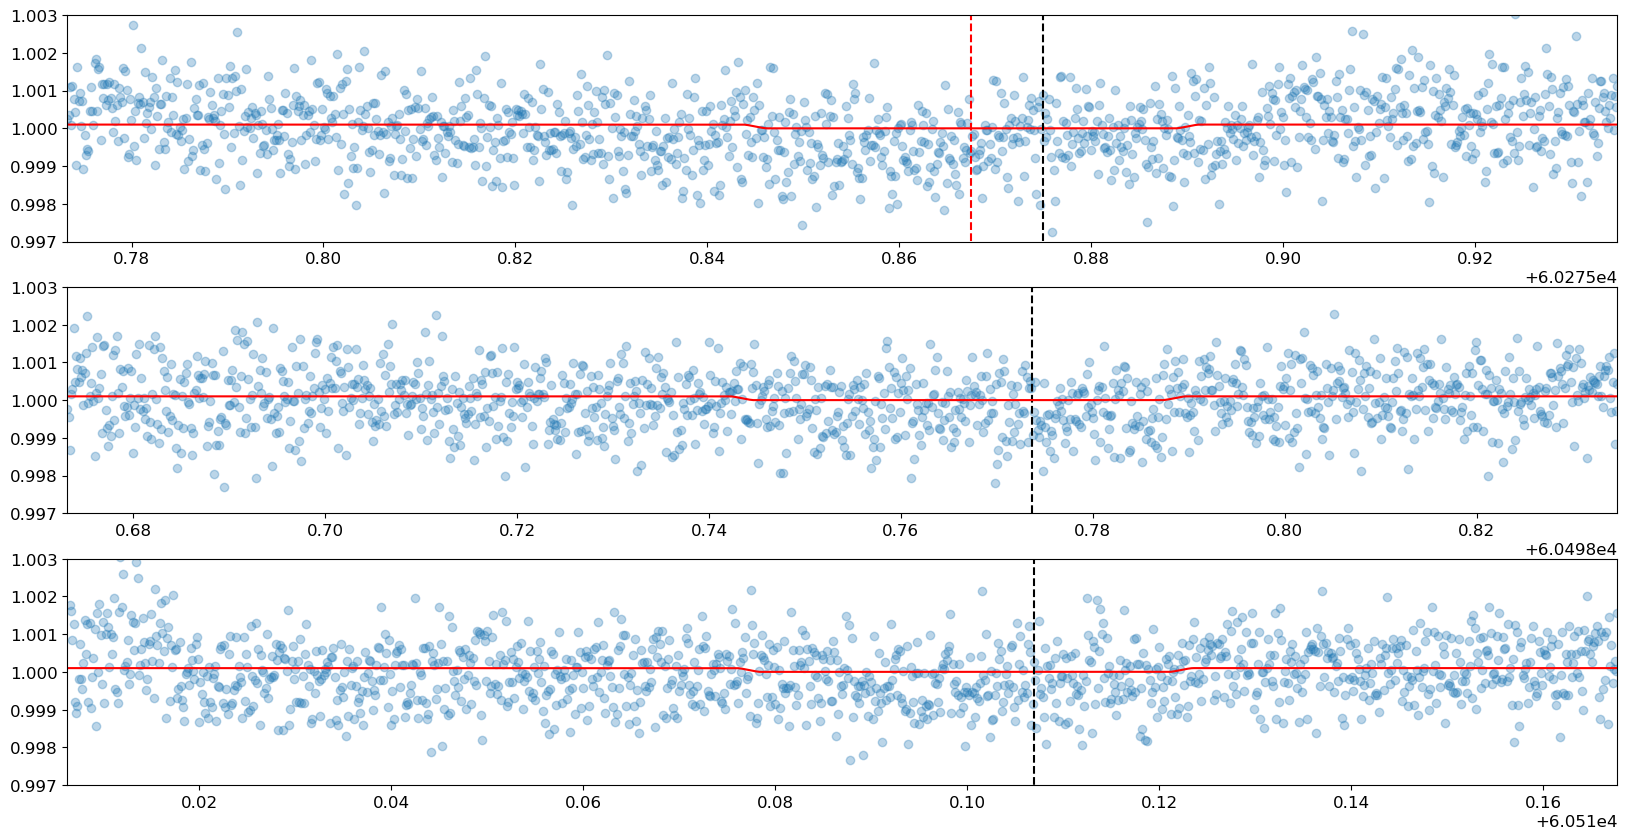

In [50]:
# plot the  eclipses with the raw flux
t_s = p0_mcmc[0]
fp = p0_mcmc[1]
flux = transit_model(time_arr, t_s, fp)
plt.figure(figsize=(20, 2))
plt.plot(time_arr, flux, '-r')
plt.ylim(0.997, 1.003)


#plt.xlim(5200, 5400)

fig, ax = plt.subplots(3, 1, figsize=(20, 10))
ax[0].errorbar(time_arr, norm_amps_arr, yerr=amps_err_arr, alpha=0.3)
ax[0].plot(time_arr, flux, '-r')
ax[0].vlines(ecl1, 0.99, 1.01, color='k', linestyle='--')
ax[0].set_xlim(time_arr[0], time_arr[1259])
ax[0].set_ylim(0.997, 1.003)

ax[1].errorbar(time_arr, norm_amps_arr, yerr=amps_err_arr, alpha=0.3)
ax[1].vlines(ecl2, 0.99, 1.01, color='k', linestyle='--')
ax[1].plot(time_arr, flux, '-r')
ax[1].set_xlim(time_arr[1260], time_arr[2519])
ax[1].set_ylim(0.997, 1.003)

ax[2].errorbar(time_arr, norm_amps_arr, yerr=amps_err_arr, alpha=0.3)
ax[2].plot(time_arr, flux, '-r')
ax[2].vlines(ecl3, 0.99, 1.01, color='k', linestyle='--')
ax[2].set_xlim(time_arr[2520], time_arr[-1])
ax[2].set_ylim(0.997, 1.003)

fig, ax = plt.subplots(3, 1, figsize=(20, 10))
ax[0].scatter(time_arr, norm_amps_arr, alpha=0.3)
ax[0].plot(time_arr, flux, '-r')
ax[0].vlines(ecl1, 0.99, 1.01, color='k', linestyle='--')
ax[0].vlines(t_s, 0.99, 1.01, color='r', linestyle='--')
ax[0].set_xlim(time_arr[0], time_arr[1259])
ax[0].set_ylim(0.997, 1.003)

ax[1].scatter(time_arr, norm_amps_arr, alpha=0.3)
ax[1].vlines(ecl2, 0.99, 1.01, color='k', linestyle='--')
ax[1].plot(time_arr, flux, '-r')
ax[1].set_xlim(time_arr[1260], time_arr[2519])
ax[1].set_ylim(0.997, 1.003)

ax[2].scatter(time_arr, norm_amps_arr, alpha=0.3)
ax[2].plot(time_arr, flux, '-r')
ax[2].vlines(ecl3, 0.99, 1.01, color='k', linestyle='--')
ax[2].set_xlim(time_arr[2520], time_arr[-1])
ax[2].set_ylim(0.997, 1.003)



In [43]:
print(fp*1e6)

99.86700590197914


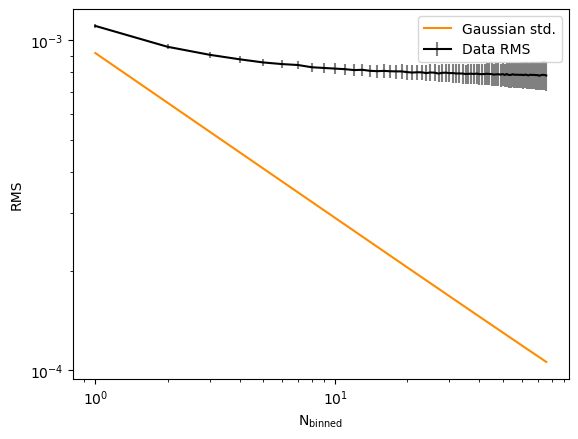

<ErrorbarContainer object of 3 artists>

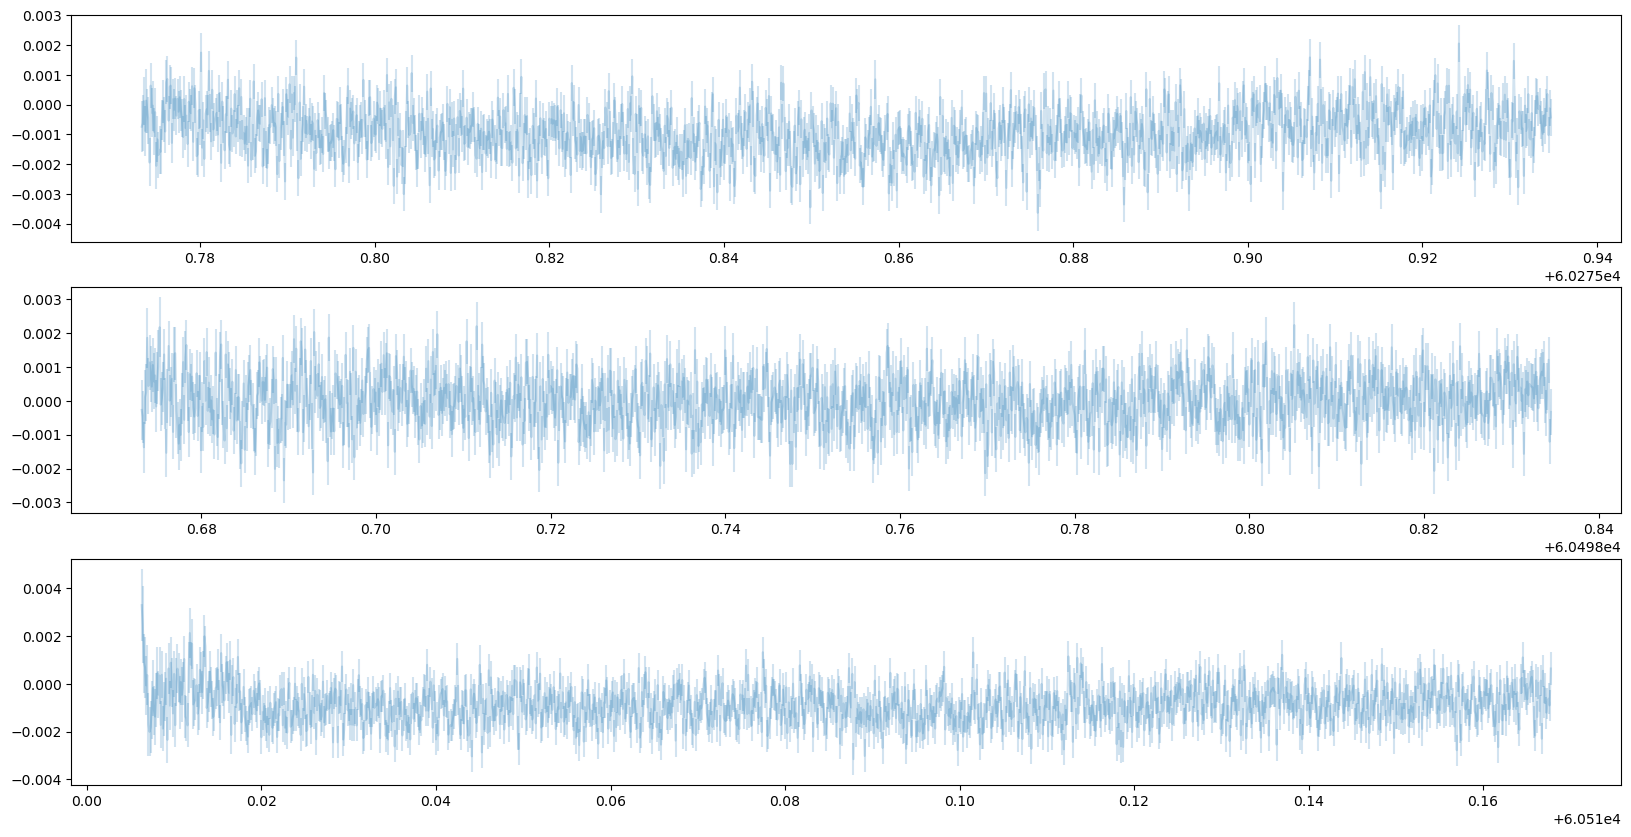

In [44]:
def plot_rednoise(residuals, minbins, occDuration = None, showPlot=True, fname=None, fontsize=10):
    
    maxbins = int(np.rint(residuals.size/minbins))
    
    try:
        rms, rmslo, rmshi, stderr, binsz = time_avg(residuals, maxbins)
    except:
        rms = []
        for i in range(minbins,len(residuals)):
            rms.append(helpers.binnedNoise(np.arange(len(residuals)),residuals,i))
        rms = np.array(rms)[::-1]

        binsz = len(residuals)/np.arange(minbins,len(residuals))[::-1]

        #In case there is a NaN or something while binning
        binsz = binsz[np.isfinite(rms)]
        rms = rms[np.isfinite(rms)]
        rmslo = np.zeros_like(rms)
        rmshi = rmslo
        stderr = np.std(residuals)/np.sqrt(binsz)
    
    plt.clf()
    ax = plt.gca()
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.errorbar(binsz, rms, yerr=[rmslo, rmshi], fmt="k-", ecolor='0.5', capsize=0, label="Data RMS")
    ax.plot(binsz, stderr, c='darkorange', label="Gaussian std.")
    ylim = ax.get_ylim()
    if occDuration is not None:
        ax.plot([occDuration,occDuration],ylim, color='black', ls='-.', alpha=0.6)
    ax.set_ylim(ylim)
    
    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
    
    plt.xlabel(r'N$_{\rm binned}$', fontsize=fontsize)
    plt.ylabel('RMS', fontsize=fontsize)
    plt.legend(loc='best', fontsize=fontsize)
    if fname is not None:
        plt.savefig(fname)

    if showPlot:
        plt.show()
    
    plt.close()

residuals = amps_arr - flux
plot_rednoise(residuals, 50)
fig, ax = plt.subplots(3,1, figsize=(20, 10))
ax[0].errorbar(time_arr[0:1259], residuals[0:1259], yerr=amps_err_arr[0:1259], alpha=0.2)
ax[1].errorbar(time_arr[1260:2519], residuals[1260:2519], yerr=amps_err_arr[1260:2519], alpha=0.2)
ax[2].errorbar(time_arr[2520:], residuals[2520:], yerr=amps_err_arr[2520:], alpha=0.2)


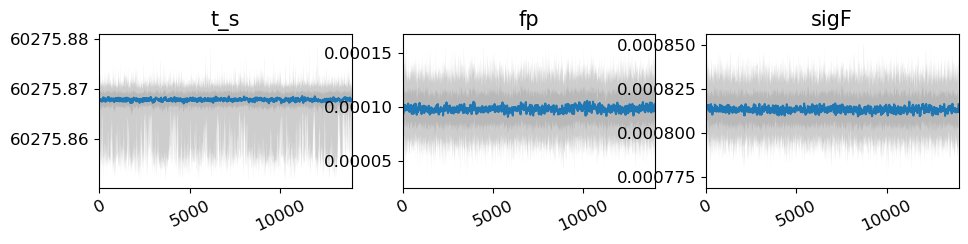

In [45]:
def walk_style(chain, labels, interv=10, fname=None, showPlot=False, fontsize=15):
    nwalk = chain.shape[0]
    ndim = chain.shape[-1]

    # get first index
    beg   = 0
    end   = len(chain[0,:,0])
    step  = np.arange(beg,end)
    step  = step[::interv]

    # number of columns and rows of subplots
    ncols = 4
    nrows = int(np.ceil(ndim/ncols))
    sizey = 2*nrows

    # plotting
    plt.figure(figsize = (15, 2*nrows))
    for ind in range(ndim):
        plt.subplot(nrows, ncols, ind+1)
        sig1 = (0.6827)/2.*100
        sig2 = (0.9545)/2.*100
        sig3 = (0.9973)/2.*100
        percentiles = [50-sig3, 50-sig2, 50-sig1, 50, 50+sig1, 50+sig2, 50+sig3]
        neg3sig, neg2sig, neg1sig, mu_param, pos1sig, pos2sig, pos3sig = np.percentile(chain[:,:,ind][:,beg:end:interv],
                                                                                       percentiles, axis=0)
        plt.plot(step, mu_param)
        plt.fill_between(step, pos3sig, neg3sig, facecolor='k', alpha = 0.1)
        plt.fill_between(step, pos2sig, neg2sig, facecolor='k', alpha = 0.1)
        plt.fill_between(step, pos1sig, neg1sig, facecolor='k', alpha = 0.1)
        plt.title(labels[ind], fontsize=fontsize)
        plt.xlim(np.min(step), np.max(step))
        if ind < (ndim - ncols):
            plt.xticks([])
        else:
            plt.xticks(rotation=25)

        y_formatter = ScalarFormatter(useOffset=False)
        plt.gca().yaxis.set_major_formatter(y_formatter)
        plt.gca().xaxis.set_tick_params(labelsize=fontsize*0.8)
        plt.gca().yaxis.set_tick_params(labelsize=fontsize*0.8)

    if fname != None:
        plt.savefig(fname, bbox_inches='tight')

    if showPlot:
        plt.show()

    #plt.close()
    return

walk_style(chain, p0_labels, interv=10, showPlot=True, fontsize=15)

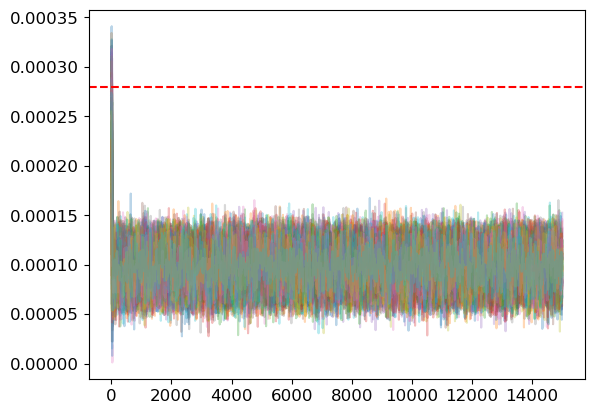

In [51]:
plt.plot(sampler.chain[:, :, 1].T, alpha=0.3)
plt.axhline(0.00028, color='r', linestyle='--')

In [54]:
print((t_s-ecl1)*24*60)

-10.803619504440576


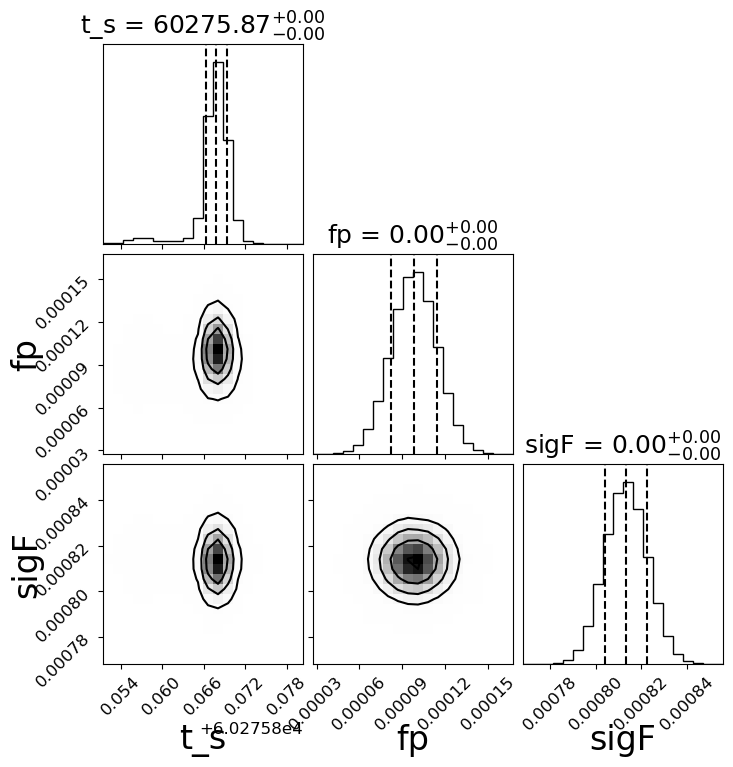

In [46]:
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 

samples = chain.reshape((-1, ndim))
fig = corner.corner(samples, quantiles=[0.16, 0.5, 0.84], labels = p0_labels, show_titles=True,
                        plot_datapoints=False, label_kwargs={"fontsize": 24}, title_kwargs={"fontsize": 18}, quiet=False)

#plt.close()

## Try binned arrays instead

(60275.77672542595, 60275.93820340854)

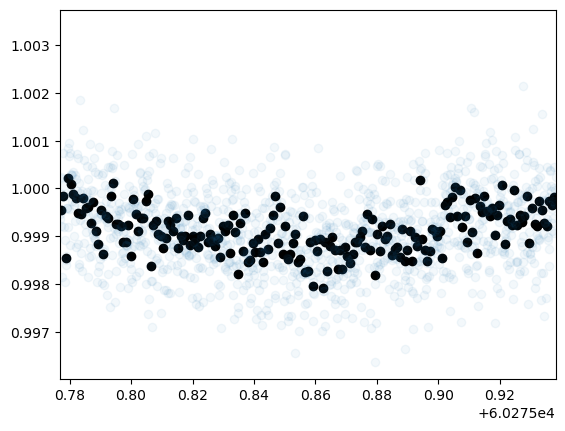

In [9]:
def binValues(values, binAxisValues, nbin, assumeWhiteNoise=True):
    bins = np.linspace(np.nanmin(binAxisValues), np.nanmax(binAxisValues), nbin)
    digitized = np.digitize(binAxisValues, bins)
    binned = np.array([np.nanmedian(values[digitized == i]) for i in range(1, nbin)])
    binnedErr = np.nanmean(np.array([np.nanstd(values[digitized == i]) for i in range(1, nbin)]))
    if assumeWhiteNoise:
        binnedErr /= np.sqrt(len(values)/nbin)
    return binned

eclipses = ['1', '2', '3']
nbin = 200
bins_time = {e: [] for e in eclipses}
bins_amps = {e: [] for e in eclipses}

for i, e in enumerate(eclipses): 
    bins_time[e] = binValues(time[e], time[e], nbin)
    bins_amps[e] = binValues(amps[e], time[e], nbin)


bins_amps_arr = np.concatenate([bins_amps['1'], bins_amps['2'], bins_amps['3']])
bins_time_arr = np.concatenate([bins_time['1'], bins_time['2'], bins_time['3']])

plt.plot(bins_time_arr, bins_amps_arr, 'o', color='k', label='Binned data')
plt.plot(time_arr, amps_arr, 'o', alpha=0.05, label='Data')
plt.xlim(time_arr[0], time_arr[1259])

In [10]:
# MCMC functions
def log_likelihood(theta, time, flux):
    t_s, fp, sigF = theta  # time of secondary eclipse
    model = transit_model(time, t_s, fp)
    sigma2 = sigF**2
    return -0.5 * np.sum((flux - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    prior = 0.
    t_s = theta[0]
    fp = theta[1]
    sigF = theta[2]
    
    if (0 < fp < 1 and (ecl1 - (e_dur_days/2)) < t_s < (ecl1 + (e_dur_days/2)) and sigF > 0.):
        return 0.0 + prior
    return np.inf

def log_prob(theta, time, flux):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, time, flux)

In [17]:
p0_astro = np.array([ecl1, 0.000270]) 
p0 = np.concatenate((p0_astro, [0.001]))
nsteps, nwalkers, ndim = 15000, 70, len(p0)

amps_test = np.concatenate([amps['2'], amps['3']])
time_test = np.concatenate([time['2'], time['3']])
amps_err_arr = np.concatenate([amps_err['2'], amps_err['3']])

# lower the initial position scatter
pos = p0 + 1e-3 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(time['1'], amps['1']))

pos2, prob, state = sampler.run_mcmc(pos, nsteps, progress=True)

100%|██████████| 15000/15000 [01:35<00:00, 157.29it/s]


In [12]:
nBurnInSteps2 = 1000
lnprobchain = sampler.get_log_prob(discard=nBurnInSteps2).swapaxes(0,1)
chain = sampler.get_chain(discard=nBurnInSteps2).swapaxes(0,1)

# Save the chains
savepath = 'EtienneFits/try4-bins-joint_'
pathchain = savepath + 'samplerchain.npy'
pathlnlchain = savepath + 'samplerlnlchain.npy'
pathposit = savepath + 'samplerposi.npy'
pathlnpro = savepath + 'samplerlnpr.npy'
np.save(pathchain, chain)
np.save(pathlnlchain, lnprobchain)
np.save(pathposit, pos2)
np.save(pathlnpro, prob)

#tries
# 2 fp centered at min limit
# 3 stricter prior on fp

In [26]:
samples = chain.reshape((-1, ndim))

MCMC_Results = np.array(list(map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84],axis=0)))))

maxk, maxiter = np.unravel_index((lnprobchain).argmax(), (lnprobchain).shape)
p0_mcmc = chain[maxk, maxiter,:]
for i in range(len(p0_mcmc)):
    MCMC_Results[i] = (p0_mcmc[i], MCMC_Results[i][1], MCMC_Results[i][2])

p0_labels = ['t_s','fp', 'sigF']
p0_labels[ndim-1] ='sigF'

out = "MCMC result:\n\n"
for i in range(len(p0_mcmc)):
    out += '{:>8} = {:>16}  +{:>16}  -{:>16}\n'.format(p0_labels[i],MCMC_Results[i][0], MCMC_Results[i][1], MCMC_Results[i][2])
print(out, flush=True)
textfile = savepath + 'results.txt'
with open(textfile, 'w') as f:
    f.write(out)


MCMC result:

     t_s = 60275.8748638581  +8.347477705683559e-05  -0.00010739127174019814
      fp = 0.00016398450700805923  +0.00011350713871125287  -0.00011942914017253024
    sigF = 0.0011725717188484164  +8.752807551434903e-05  -9.455293170025506e-05



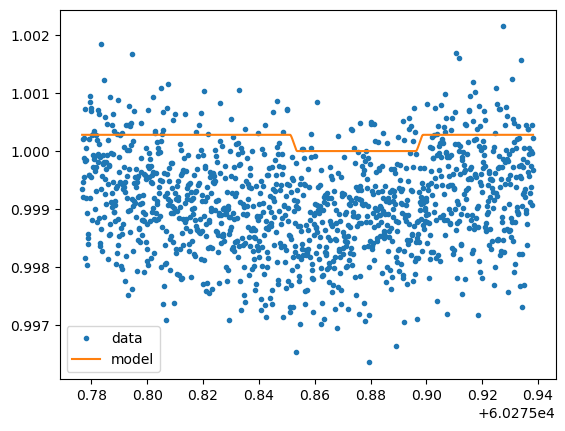

In [20]:
plt.plot(time['1'], amps['1'], '.', label="data")
plt.plot(time['1'], transit_model(time['1'], ecl1, 0.00028), label="model")
plt.legend()

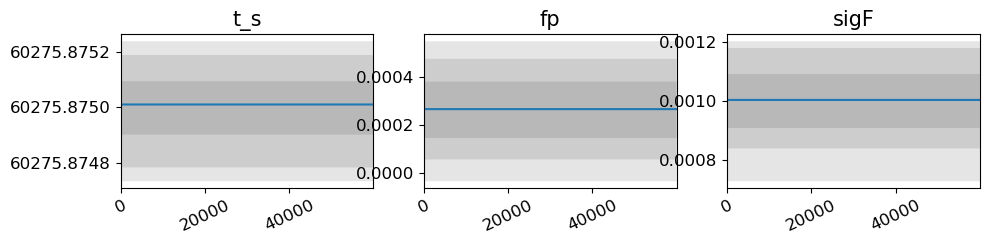

In [27]:
def walk_style(chain, labels, interv=10, fname=None, showPlot=False, fontsize=15):
    nwalk = chain.shape[0]
    ndim = chain.shape[-1]

    # get first index
    beg   = 0
    end   = len(chain[0,:,0])
    step  = np.arange(beg,end)
    step  = step[::interv]

    # number of columns and rows of subplots
    ncols = 4
    nrows = int(np.ceil(ndim/ncols))
    sizey = 2*nrows

    # plotting
    plt.figure(figsize = (15, 2*nrows))
    for ind in range(ndim):
        plt.subplot(nrows, ncols, ind+1)
        sig1 = (0.6827)/2.*100
        sig2 = (0.9545)/2.*100
        sig3 = (0.9973)/2.*100
        percentiles = [50-sig3, 50-sig2, 50-sig1, 50, 50+sig1, 50+sig2, 50+sig3]
        neg3sig, neg2sig, neg1sig, mu_param, pos1sig, pos2sig, pos3sig = np.percentile(chain[:,:,ind][:,beg:end:interv],
                                                                                       percentiles, axis=0)
        plt.plot(step, mu_param)
        plt.fill_between(step, pos3sig, neg3sig, facecolor='k', alpha = 0.1)
        plt.fill_between(step, pos2sig, neg2sig, facecolor='k', alpha = 0.1)
        plt.fill_between(step, pos1sig, neg1sig, facecolor='k', alpha = 0.1)
        plt.title(labels[ind], fontsize=fontsize)
        plt.xlim(np.min(step), np.max(step))
        if ind < (ndim - ncols):
            plt.xticks([])
        else:
            plt.xticks(rotation=25)

        y_formatter = ScalarFormatter(useOffset=False)
        plt.gca().yaxis.set_major_formatter(y_formatter)
        plt.gca().xaxis.set_tick_params(labelsize=fontsize*0.8)
        plt.gca().yaxis.set_tick_params(labelsize=fontsize*0.8)

    if fname != None:
        plt.savefig(fname, bbox_inches='tight')

    if showPlot:
        plt.show()

    #plt.close()
    return

walk_style(chain, p0_labels, interv=10, showPlot=True, fontsize=15)

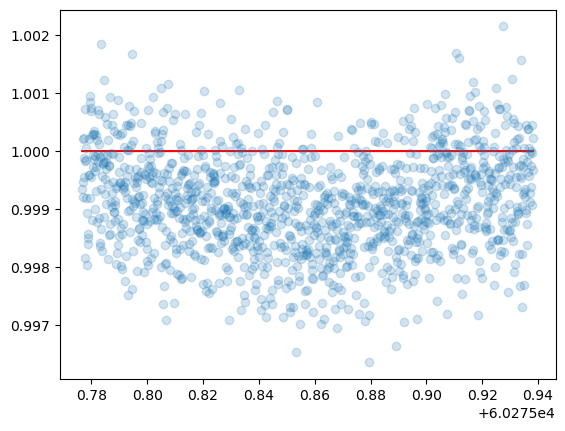

In [15]:
t_s = p0_mcmc[0]
fp = p0_mcmc[1]
flux = transit_model(time['1'], t_s, fp)
plt.plot(time['1'], flux, '-r')
plt.plot(time['1'], amps['1'], 'o', alpha=0.2, label='Data')

(0.998, 1.002)

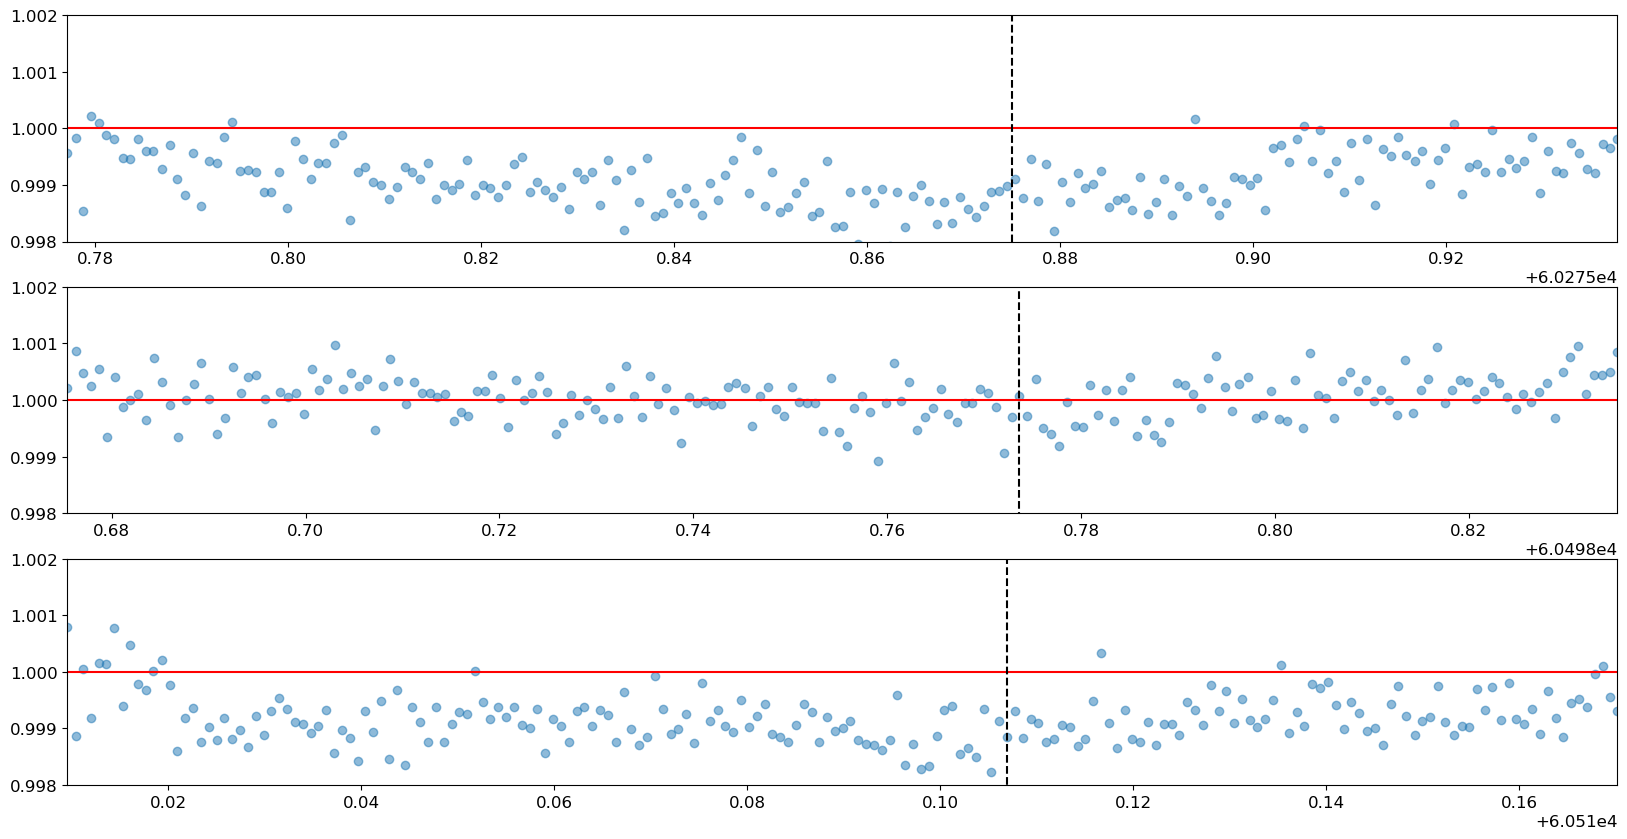

In [153]:
t_s = p0_mcmc[0]
fp = p0_mcmc[1]
flux = transit_model(bins_time_arr, t_s, fp)

fig, ax = plt.subplots(3, 1, figsize=(20, 10))
ax[0].scatter(bins_time_arr, bins_amps_arr, alpha=0.5, marker='o')
ax[0].plot(bins_time_arr, flux, '-r')
ax[0].vlines(ecl1, 0.99, 1.01, color='k', linestyle='--')
ax[0].set_xlim(bins_time_arr[0], bins_time_arr[198])
ax[0].set_ylim(0.998, 1.002)

ax[1].scatter(bins_time_arr, bins_amps_arr, alpha=0.5, marker='o')
ax[1].vlines(ecl2, 0.99, 1.01, color='k', linestyle='--')
ax[1].plot(bins_time_arr, flux, '-r')
ax[1].set_xlim(bins_time_arr[199], bins_time_arr[-201])
ax[1].set_ylim(0.998, 1.002)

ax[2].scatter(bins_time_arr, bins_amps_arr, alpha=0.5, marker='o')
ax[2].plot(bins_time_arr, flux, '-r')
ax[2].vlines(ecl3, 0.99, 1.01, color='k', linestyle='--')
ax[2].set_xlim(bins_time_arr[-199], bins_time_arr[-1])
ax[2].set_ylim(0.998, 1.002)

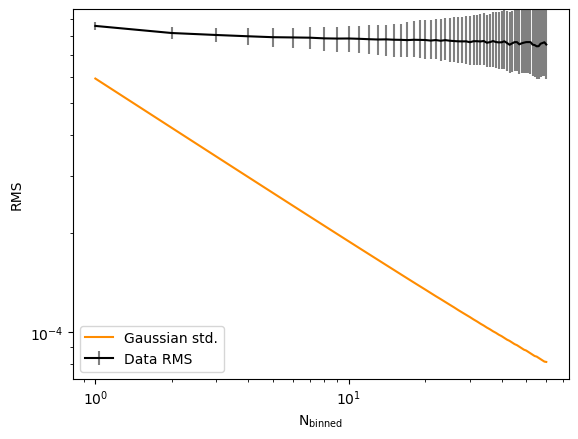

In [123]:
def plot_rednoise(residuals, minbins, occDuration = None, showPlot=True, fname=None, fontsize=10):
    
    maxbins = int(np.rint(residuals.size/minbins))
    
    try:
        rms, rmslo, rmshi, stderr, binsz = time_avg(residuals, maxbins)
    except:
        rms = []
        for i in range(minbins,len(residuals)):
            rms.append(helpers.binnedNoise(np.arange(len(residuals)),residuals,i))
        rms = np.array(rms)[::-1]

        binsz = len(residuals)/np.arange(minbins,len(residuals))[::-1]

        #In case there is a NaN or something while binning
        binsz = binsz[np.isfinite(rms)]
        rms = rms[np.isfinite(rms)]
        rmslo = np.zeros_like(rms)
        rmshi = rmslo
        stderr = np.std(residuals)/np.sqrt(binsz)
    
    plt.clf()
    ax = plt.gca()
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.errorbar(binsz, rms, yerr=[rmslo, rmshi], fmt="k-", ecolor='0.5', capsize=0, label="Data RMS")
    ax.plot(binsz, stderr, c='darkorange', label="Gaussian std.")
    ylim = ax.get_ylim()
    if occDuration is not None:
        ax.plot([occDuration,occDuration],ylim, color='black', ls='-.', alpha=0.6)
    ax.set_ylim(ylim)
    
    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
    
    plt.xlabel(r'N$_{\rm binned}$', fontsize=fontsize)
    plt.ylabel('RMS', fontsize=fontsize)
    plt.legend(loc='best', fontsize=fontsize)
    if fname is not None:
        plt.savefig(fname)

    if showPlot:
        plt.show()
    
    plt.close()

residuals = bins_amps_arr - flux
plot_rednoise(residuals, 10)


In [25]:
# # load previous results
path = 'EtienneFits/try6-70000steps-joint_'
chain = np.load(path +'samplerchain_10000.npy')
lnprobchain = np.load(path  + 'samplerlnlchain_10000.npy')
pos2 = np.load(path + 'samplerlnlchain_10000.npy')
prob = np.load(path + 'samplerlnlchain_10000.npy')